1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [1]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2')
bdu_all = correct(bdu_all)


In [2]:
bdu_all.shape 

(1327, 216)

Setup the experiment:

In [3]:
best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

alpha = 0.5
alpha_2 = 0.84

x_variants = ['n1_peak', 'n1a_peak', 'n1c2_peak', 'n1com_peak', 'n1max_peak', 'n2a_peak', 'nf_peak']
y_variants = ['egt', 'egt_peak', 'egtb']
theta_variants = ['oat', 'oat_peak', 't2', 't2_peak', 'tat', 'tat_peak']

hall_of_fame = []

In [11]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = 0.84):
  theta = (data[theta_param] + 273.16) / 288.16
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 200
      baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [7]:
pd.DataFrame(hall_of_fame).sort_values('rmse')

,x_param,y_param,theta_param,rmse
100,n2a_peak,egt_peak,tat,1.254806
101,n2a_peak,egt_peak,tat_peak,1.485887
97,n2a_peak,egt_peak,oat_peak,1.489908
99,n2a_peak,egt_peak,t2_peak,1.550232
63,n1com_peak,egt_peak,t2_peak,1.574977
...,...,...,...,...
82,n1max_peak,egt_peak,tat,7.477909
83,n1max_peak,egt_peak,tat_peak,7.497612
81,n1max_peak,egt_peak,t2_peak,7.509357
77,n1max_peak,egt,tat_peak,7.521197


Plot best result: 

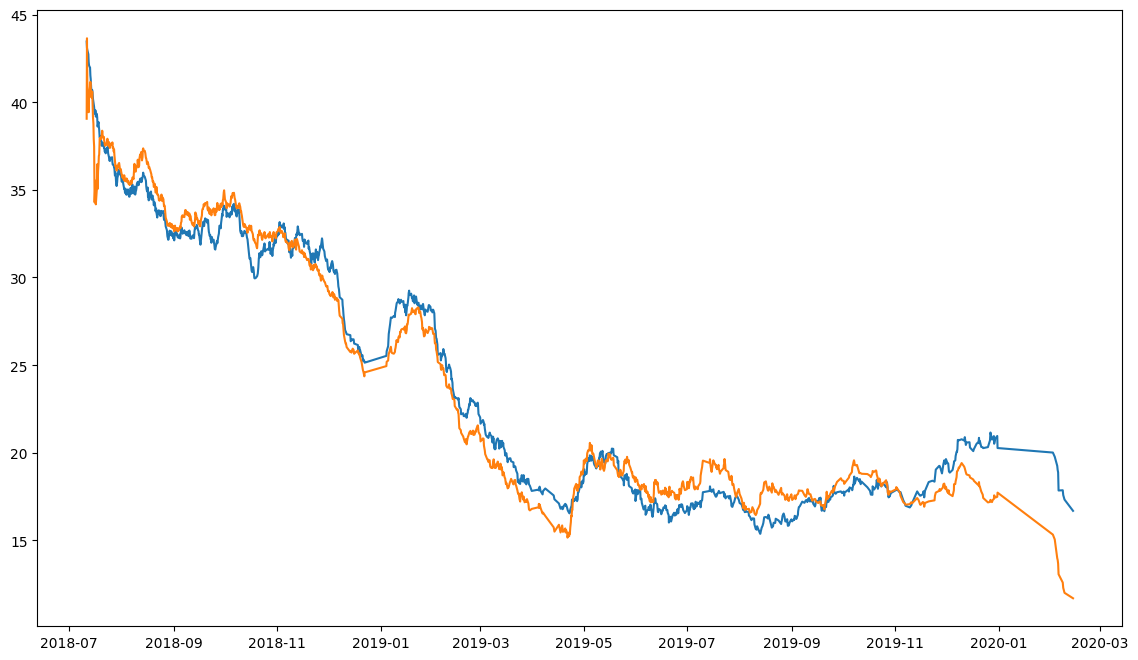

In [8]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

finetune coefficients for corrections

In [9]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 'tat')

In [16]:
for a in range(80, 99, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / 100))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  print(a, rmse)


80 2.3411580665285108
81 2.055588204189438
82 1.774242334930146
83 1.5038000760107035
84 1.2548064458776376
85 1.0447204822015734
86 0.9009444218084034
87 0.8547353381706947
88 0.9161966553908875
89 1.0612718622688133
90 1.2556633620440447
91 1.4745235130609722
92 1.7033487611644664
93 1.9339846535204648
94 2.161745193145819
95 2.3838599771131226
96 2.598670464852144
97 2.8052009824903843
98 3.00291697120595
